In [ ]:
#TODO: ESTR AS daily returns
#TODO: Include beta calculation/adjustments in the process
#TODO: Defensive vs offensive allocation

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from utility.types import (
    RebalanceFrequencyEnum,
    AllocationMethodsEnum,
    RegimeDetectionModels,
)

from data.universe import Universe
from data.benchmark import Benchmark

from backtest.backtest import Backtester

In [2]:
bench_obj = Benchmark(RebalanceFrequencyEnum.MONTH_END)
bench_obj.benchmark_perf

Creating benchmark...:  30%|██▉       | 1057/3568 [00:02<00:04, 519.39it/s]c:\_sharedFS\Ecole\Cross-Asset-Investment-Solutions\Cross-Asset-Investment-Solutions\src\data\benchmark.py:48: RuntimeWarning: invalid value encountered in matmul
  self.__benchmark_components_returns[list(weights.keys())]
c:\_sharedFS\Ecole\Cross-Asset-Investment-Solutions\Cross-Asset-Investment-Solutions\src\utility\utils.py:72: RuntimeWarning: invalid value encountered in multiply
  (old_weights * (current_returns + 1))
c:\_sharedFS\Ecole\Cross-Asset-Investment-Solutions\Cross-Asset-Investment-Solutions\src\utility\utils.py:73: RuntimeWarning: invalid value encountered in matmul
  / ((current_returns + 1) @ old_weights),


2010-07-06    1.000000
2010-07-07    1.005501
2010-07-08    1.003922
2010-07-09    1.005783
2010-07-12    1.008098
                ...   
2024-03-01    3.242063
2024-03-04    3.250226
2024-03-05    3.243347
2024-03-06    3.242911
2024-03-07    3.262965
Freq: B, Name: benchmark_perf, Length: 3568, dtype: float64

In [3]:
univ_obj = Universe(keep_only_benchmark_universe=False)
universe = univ_obj.get_universe_returns()
universe

,EUROPE _VALUE_FACTOR,WATER_ESG,STOXX_EUROPE 600_TECHNOLOGY,STOXX_EUROPE 600_HEALTHCARE,EPSILON_TREND,Px fut SX5E,Px fut sp500,Px fut nasdaq,SX5T,SPTR500N,ESTR_ETF
2011-04-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-04-18,-0.019838,-0.008338,-0.015371,-0.005608,-0.023932,-0.023910,-0.013460,-0.008551,-0.024178,-0.003812,-0.009649
2011-04-19,0.002565,-0.001201,-0.000905,0.003589,0.011258,0.001801,0.005765,0.009170,0.003744,0.008637,0.001771
2011-04-20,0.018252,0.011425,0.026495,0.017625,0.022580,0.023013,0.015094,0.019039,0.022820,0.000976,0.074271
2011-04-21,0.002988,0.001189,0.010368,-0.002259,0.005438,0.008436,0.002070,0.008705,0.006865,-0.002491,0.180247
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,0.004568,0.005994,0.015707,0.013283,0.003002,0.001430,0.008278,0.014129,0.001428,0.004299,0.004374
2024-03-04,-0.003465,0.003610,0.007408,0.004546,0.005692,0.003469,-0.001506,-0.004158,0.004018,0.002917,-0.000256
2024-03-05,0.002646,-0.005968,-0.016467,-0.005092,0.000850,-0.004270,-0.010217,-0.018166,-0.004131,-0.003285,0.002050
2024-03-06,0.003564,0.000316,0.012498,0.001467,0.001088,0.005105,0.005112,0.006358,0.005315,-0.011630,-0.001534


C:\Users\bzloch\AppData\Local\Temp\ipykernel_1864\4177489834.py:6: RuntimeWarning: divide by zero encountered in divide
  return long_term_value -((long_term_value - initial_value) * (1 - np.exp( -smoothing_lambda / current_value)))


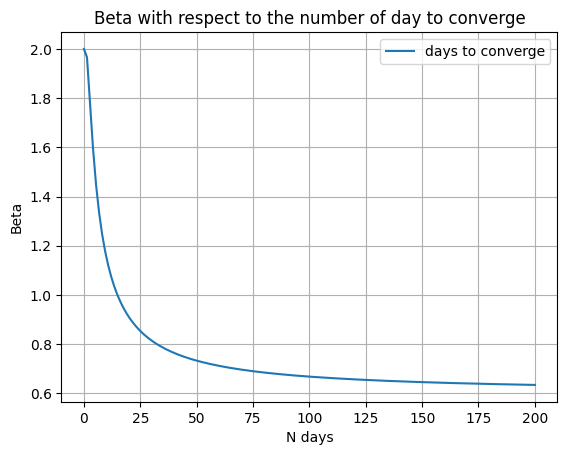

In [4]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 200, 150)
def converging_value(current_value,initial_value, long_term_value, smoothing_lambda):
  assert 0.1 <= long_term_value <= 3 and 0.1 <= initial_value <= 3  ,"long_term_value must be between 0.1 and 3"
  return long_term_value -((long_term_value - initial_value) * (1 - np.exp( -smoothing_lambda / current_value)))

# Example usage
long_term_value = 0.6
initial_value = 2
# value_at_day = converging_value(long_term_value, convergence_speed, initial_value)
plt.plot(x,converging_value(x, initial_value,long_term_value,5),label="days to converge")
plt.title('Beta with respect to the number of day to converge')
plt.xlabel('N days')
plt.ylabel('Beta')
plt.grid()
plt.legend()

In [ ]:
bk_tester = Backtester(
    universe_returns=univ_obj.get_universe_returns(),
    market_returns=univ_obj.get_universe_returns()["SPTR500N"],
    benchmark_returns=bench_obj.benchmark_returns,
)

ptf_and_bench, ptf_weights_equal_weight, regimes, metrics_df = bk_tester.run_backtest(
    rebalance_frequency=RebalanceFrequencyEnum.MONTH_END,
    regime_frequency=RebalanceFrequencyEnum.MONTH_END,
    market_regime_model=RegimeDetectionModels.HIDDEN_MARKOV_MODEL,
    # bearish_leverage_by_securities={"SX5T": 0.9, "SPTR500N": 0.9},
    # bullish_leverage_by_securities={"SX5T": 1.1, "SPTR500N": 1.1},
    verbose=False,
)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))


ax.plot(regimes.index, regimes.next_beta, label="Beta")
ax_l = ax.twinx()
ax_l.fill_between(
    regimes.index,
    regimes["Regime"],
    alpha=0.2,
    color="red",
    step="pre",
)
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Beta", fontsize=15)
ax.set_title(f"Dynamic beta evolution", fontsize=20)
ax.grid()
ax.legend(fontsize=15)